## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.utils import compute_class_weight

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.ensemble import AdaBoostClassifier


In [2]:
## import data when available
data = pd.read_csv('raw_data/wingman_data_proc_v5.csv')
data.set_index('id', inplace=True)

In [3]:
data

,subcategory_no,num_eng,total_seats,afm_hrs,cert_max_gr_wt,dprt_time,power_units,flight_hours_mean,certs_held,second_pilot,...,eng_type_infrequent_sklearn,carb_fuel_injection_CARB,carb_fuel_injection_FINJ,carb_fuel_injection_UNK,dprt_apt_id,dest_apt_id,flt_plan_filed_IFR,flt_plan_filed_NONE,flt_plan_filed_VFR,pc_profession
id,,,,,,,,,,,,,,,,,,,,,
20080115X000511,6,1,2,5835,1670,2215,110,18.000000,1.0,0.0,...,0.0,1.0,0.0,0.0,1,1,0.0,1.0,0.0,0
20080116X000631,3,2,10,13130,7368,1743,350,9437.000000,1.0,0.0,...,0.0,0.0,1.0,0.0,1,1,0.0,0.0,1.0,1
20080122X000871,5,1,7,3895,5000,2331,674,3120.000000,1.0,0.0,...,1.0,0.0,0.0,1.0,1,0,0.0,0.0,1.0,1
20080220X002121,6,1,2,1100,1650,1630,150,4600.000000,1.0,0.0,...,0.0,1.0,0.0,0.0,0,0,0.0,1.0,0.0,0
20080207X001531,4,1,5,3227,2450,1630,400,6500.000000,1.0,0.0,...,1.0,0.0,0.0,1.0,1,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190107X337411,2,1,4,9805,2270,2100,225,1877.000000,1.0,0.0,...,0.0,1.0,0.0,0.0,1,1,0.0,1.0,0.0,0
20190121X128521,7,1,4,3899,2550,1315,230,611.400024,1.0,0.0,...,0.0,1.0,0.0,0.0,1,1,0.0,1.0,0.0,0
20190108X549451,4,1,2,6177,1369,1630,160,1525.000000,1.0,1.0,...,0.0,1.0,0.0,0.0,1,1,0.0,1.0,0.0,1


## Train test split

In [4]:
X = data.drop('subcategory_no', axis=1)
y = data['subcategory_no']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Baseline model

In [5]:
model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)

In [6]:
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [7]:
## baseline prediction

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.5368898978433598

In [8]:
f1_score(y_test, y_pred, average='weighted')

0.43152830117440644

In [9]:
data['subcategory_no'].value_counts()
len(data['subcategory_no'])

data['subcategory_no'].value_counts()/len(data['subcategory_no'])

subcategory_no
6    0.535003
5    0.161472
2    0.156191
7    0.086357
4    0.029978
3    0.024527
1    0.006472
Name: count, dtype: float64

## Randomized search

In [29]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [30]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2500, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 250, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 25, 35]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10, 15, 20, 30]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [31]:
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 10, cv = 5, random_state=1, n_jobs = 1, verbose=3)

model_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV 1/5] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=35, n_estimators=1433;, score=0.530 total time=  10.1s
[CV 2/5] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=35, n_estimators=1433;, score=0.530 total time=   3.1s
[CV 3/5] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=35, n_estimators=1433;, score=0.530 total time=   3.5s
[CV 4/5] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=35, n_estimators=1433;, score=0.530 total time=   3.8s
[CV 5/5] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=35, n_estimators=1433;, score=0.531 total time=   3.8s
[CV 1/5] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=35, n_estimators=633;, score=0.530 total time=   2.5s
[CV 2/5] END bootstrap=False, max_depth=5, max_features=log2, min_samples_le

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 32, 59, 86, 113, 141,
                                                      168, 195, 222, 250,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10,
                                                             15, 20, 30],
                                        'min_samples_split': [2, 5, 10, 15, 25,
                                                              35],
                                        'n_estimators': [100, 366, 633, 900,
                                                         1166, 1433, 1700, 1966,
                                                         2233, 2500]},
                   random_state=1, verbose=3)

In [40]:
model_random.best_params_

{'n_estimators': 2500,
 'min_samples_split': 5,
 'min_samples_leaf': 15,
 'max_features': 'sqrt',
 'max_depth': 168,
 'bootstrap': False}

In [41]:
model_random.best_score_

0.5327323215709285

In [65]:
model_random_1 = RandomForestClassifier(n_estimators= 2500, min_samples_split=5, min_samples_leaf=15, 
                                        max_features= 'sqrt', max_depth=168, bootstrap=False)
model_random_1.fit(X_train, y_train)
y_pred_2 = model_random_1.predict(X_test)
accuracy_score(y_test, y_pred_2)

0.5516458569807038

## SMOTE

In [103]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

In [104]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

Class=6, n=2180 (14.286%)
Class=5, n=2180 (14.286%)
Class=2, n=2180 (14.286%)
Class=7, n=2180 (14.286%)
Class=3, n=2180 (14.286%)
Class=4, n=2180 (14.286%)
Class=1, n=2180 (14.286%)


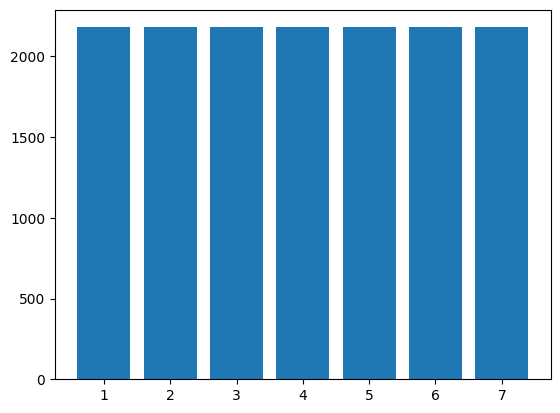

In [105]:
# summarize distribution
counter = Counter(y_smote)
for k,v in counter.items():
 per = v / len(y_smote) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

## SMOTE model

In [106]:
model_smote = RandomForestClassifier()
model_smote.fit(X_smote, y_smote)

RandomForestClassifier()

In [107]:
y_pred = model_smote.predict(X_test)

accuracy_score(y_test, y_pred)

0.5141884222474461

In [111]:
model_random_smote = RandomizedSearchCV(estimator = model_smote, param_distributions = random_grid, n_iter = 5, cv = 3, random_state=1, n_jobs = 1, verbose=3)

model_random_smote.fit(X_smote, y_smote)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=35, n_estimators=1433;, score=0.423 total time=  13.1s
[CV 2/3] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=35, n_estimators=1433;, score=0.520 total time=  14.3s
[CV 3/3] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=35, n_estimators=1433;, score=0.502 total time=  13.9s
[CV 1/3] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=35, n_estimators=633;, score=0.424 total time=   7.7s
[CV 2/3] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=35, n_estimators=633;, score=0.522 total time=   7.1s
[CV 3/3] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=35, n_estimators=633;, score=0.500 total time=   7.1s
[CV 1/3] END boo

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 32, 59, 86, 113, 141,
                                                      168, 195, 222, 250,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10,
                                                             15, 20, 30],
                                        'min_samples_split': [2, 5, 10, 15, 25,
                                                              35],
                                        'n_estimators': [100, 366, 633, 900,
                                                         1166, 1433, 1700, 1966,
                                                         2233, 2500]},
                   random_state=1, verbose=3)

In [112]:
model_random_smote.best_params_

{'n_estimators': 2500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 141,
 'bootstrap': False}

In [113]:
model_random_smote.best_score_

0.808721057376714

In [114]:
model_smote_best = RandomForestClassifier(n_estimators=2500, min_samples_split= 2,min_samples_leaf=1,
                                          max_features='log2',max_depth= 141, bootstrap=False)

model_smote_best.fit(X_smote, y_smote)



RandomForestClassifier(bootstrap=False, max_depth=141, max_features='log2',
                       n_estimators=2500)

In [115]:
model_smote_best.score(X_test, y_test)

0.5085130533484676

In [119]:
y_pred_smote = model_smote_best.predict(X_test)
accuracy_score(y_test, y_pred_smote)


0.5085130533484676

In [120]:
f1_score(y_test, y_pred_smote, average='weighted')

0.43533856283741823

## ADASYN 

In [ ]:
from imblearn.over_sampling import ADASYN

Class=6, n=2180 (14.374%)
Class=5, n=2240 (14.770%)
Class=2, n=2176 (14.348%)
Class=7, n=2085 (13.748%)
Class=3, n=2150 (14.176%)
Class=4, n=2151 (14.183%)
Class=1, n=2184 (14.401%)


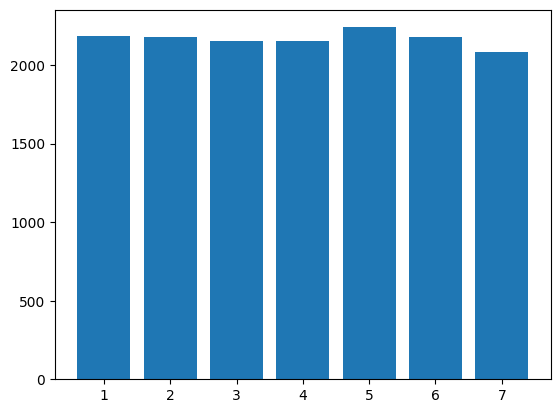

In [ ]:
ada = ADASYN()
X_ada, y_ada = ada.fit_resample(X_train, y_train)

# summarize distribution
counter = Counter(y_ada)
for k,v in counter.items():
 per = v / len(y_ada) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
model_ada = RandomForestClassifier()
model_ada.fit(X_ada, y_ada)

RandomForestClassifier()

In [ ]:
y_pred = model_ada.predict(X_test)

accuracy_score(y_test, y_pred)

0.5130533484676504

In [ ]:
model_random_ada = RandomizedSearchCV(estimator = model_ada, param_distributions = random_grid, n_iter = 10, cv = 5, random_state=1, n_jobs = 1, verbose=3)

model_random_ada.fit(X_ada, y_ada)

In [ ]:
model_random_ada.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
model_random_ada.best_score_

0.7379169065569876

In [ ]:
model_ada_best = RandomForestClassifier(n_estimators=2500, min_samples_split= 2,min_samples_leaf=1,
                                          max_features='log2',max_depth= 141, bootstrap=False)

model_ada_best.fit(X_ada, y_ada)

model_ada_best.score(X_test, y_test)

0.5107832009080591

In [ ]:
from sklearn.model_selection import learning_curve

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(model_ada_best, X_ada, y_ada, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
# Calculate the mean and standard deviation of train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, label='Cross-validation Score', color='green')

NameError: name 'model_ada_best' is not defined

In [ ]:
ada = AdaBoostClassifier(base_estimator=model_ada_best,n_estimators=100)

In [ ]:
ada = ada.fit(X_ada, y_ada)
y_pred_ada = ada.predict(X_test)
accuracy_score(y_test, y_pred_ada)

/Users/danielderbyshire/.pyenv/versions/3.10.6/envs/wingman/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.5102156640181612

## Feature selection and reduced model

In [6]:
## feature importance for randomized search model (unbalanced classes)

feat_importances = pd.Series(model_random_1.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

NameError: name 'model_random_1' is not defined

In [87]:
data['_BUS ']

id
20080115X000511    0
20080116X000631    0
20080122X000871    0
20080220X002121    0
20080207X001531    0
                  ..
20190107X337411    0
20190121X128521    0
20190108X549451    0
20190112X112141    0
20190111X427051    0
Name: _BUS , Length: 5871, dtype: int64

In [88]:
feat_importances.nsmallest(38)

_AOBV                          0.000005
site_seeing                    0.000038
air_medical                    0.000083
_BUS                           0.000364
_POSI                          0.000460
_Other                         0.000462
type_last_insp_AAIP            0.000465
type_last_insp_COAW            0.000513
certs_held                     0.000533
_OWRK                          0.000627
type_last_insp_UNK             0.000960
_FLTS                          0.001215
_AAPL                          0.001229
eng_mfgr_P&W                   0.001278
crew_sex                       0.001840
eng_type_infrequent_sklearn    0.002127
_UNK                           0.002274
eng_type_REC                   0.002315
flt_plan_filed_IFR             0.002746
num_eng                        0.002966
flt_plan_filed_VFR             0.003972
dprt_apt_id                    0.004350
type_last_insp_COND            0.004382
second_pilot                   0.004859
_INST                          0.005134


In [89]:
data_drop_feats = data.drop(columns=['_AOBV', 'site_seeing', 'air_medical', '_BUS ', '_POSI', 'type_last_insp_COAW',
                                     'certs_held', 'type_last_insp_AAIP', '_Other', '_OWRK', 'type_last_insp_UNK',
                                     '_AAPL', 'eng_mfgr_P&W', '_FLTS', 'crew_sex', '_UNK', 'eng_type_REC', 
                                     'eng_type_infrequent_sklearn', 'flt_plan_filed_IFR', 'num_eng', 
                                     'flt_plan_filed_VFR', 'type_last_insp_COND', 'dprt_apt_id', 'second_pilot',
                                     '_INST', 'eng_mfgr_infrequent_sklearn', 'eng_mfgr_ROTAX', 'type_last_insp_100H',
                                     'crew_category_FLTI', 'dest_apt_id', 'carb_fuel_injection_UNK', 'flt_plan_filed_NONE',
                                     'acft_make_PIPER', 'carb_fuel_injection_FINJ', 'pc_profession', '_PERS',
                                     'acft_make_BEECH', 'carb_fuel_injection_CARB'], axis=1)

In [90]:
X_drop = data_drop_feats.drop('subcategory_no', axis=1)
y_drop = data_drop_feats['subcategory_no']

X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(X_drop, y_drop, test_size=0.3, random_state=1)



In [91]:
model_random_2 = RandomForestClassifier(n_estimators= 2500, min_samples_split=5, min_samples_leaf=15, 
                                        max_features= 'sqrt', max_depth=168, bootstrap=False)


In [92]:
model_random_2.fit(X_train_dr, y_train_dr)


RandomForestClassifier(bootstrap=False, max_depth=168, min_samples_leaf=15,
                       min_samples_split=5, n_estimators=2500)

In [93]:
y_pred_3 = model_random_2.predict(X_test_dr)
accuracy_score(y_test_dr, y_pred_2)

0.5516458569807038

## Adaboost reduced model

In [83]:
ada = AdaBoostClassifier(base_estimator=model_random_2,n_estimators=10)

In [84]:
ada.fit(X_train_dr, y_train_dr)

/Users/danielderbyshire/.pyenv/versions/3.10.6/envs/wingman/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                         max_depth=168,
                                                         min_samples_leaf=15,
                                                         min_samples_split=5,
                                                         n_estimators=2500),
                   n_estimators=10)

In [85]:
y_pred_ada = ada.predict(X_test_dr)
accuracy_score(y_test_dr, y_pred_ada)

0.5329171396140749

## SMOTE reduced model

In [116]:
oversample = SMOTE()
X_smote_dr, y_smote_dr = oversample.fit_resample(X_train_dr, y_train_dr)

model_smote_dr = RandomForestClassifier(n_estimators =2500, min_samples_split=2, min_samples_leaf=1,
                                        max_features= 'log2', max_depth=141, bootstrap=False)
model_smote_dr.fit(X_smote_dr, y_smote_dr)

y_pred_smdr = model_smote_dr.predict(X_test_dr)

accuracy_score(y_test_dr, y_pred_smdr)

0.49545970488081725

In [7]:
from sklearn import svm 

In [8]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = svm.SVC(kernel='poly').fit(X_train, y_train)

In [9]:
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

In [10]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')

In [11]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')

In [12]:
poly_accuracy

0.5459704880817253

In [13]:
rbf_accuracy

0.5454029511918275

In [14]:
grid_list = {"C": np.arange(2, 10, 2),
             "gamma": np.arange(0.1, 1, 0.2)}

random_search = RandomizedSearchCV(poly, param_distributions = grid_list, n_iter = 5, cv = 3, random_state=1, n_jobs = 1, verbose=3) 
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
